# tmp
this is just a dump for testing

In [12]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
sys.path.insert(0, './testing/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc
import vertices as vrt

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice


In [4]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [40]:
N = 2
a = params['lattice_constant']

sp = ice.spins()
sp.create_lattice('square', [2,3], lattice_constant=a ,border='periodic')

particle = ice.particle(radius=params['particle_radius'],
                        susceptibility=params['particle_susceptibility'],
                        diffusion=params['particle_diffusion'],
                        temperature=params['particle_temperature'],
                        density=params['particle_density']
)

trap = ice.trap(trap_sep=params['trap_sep'],
                height=params['trap_height'],
                stiffness=params['trap_stiffness']
)

col = ice.colloidal_ice(sp, particle, trap,
                        height_spread=params['height_spread'],
                        susceptibility_spread=params['susceptibility_spread'],
                        periodic=params['isperiodic']
)

col.randomize()
col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a

col.to_ctrj().to_csv('array.csv')

In [122]:
trj = vrt.trj2trj(pd.read_csv('array.csv',index_col=['id']))
trj['dx'] = trj['dx']*5
trj['dy'] = trj['dy']*5
trj['dz'] = trj['dz']*5
trj

x     y    z            dx   dy   dz            cx   cy   cz
frame id                                                                 
0     0   15.0  30.0  0.0 -5.000000e+00  0.0  0.0 -5.000000e+00  0.0  0.0
      1   45.0  30.0  0.0  5.000000e+00  0.0  0.0  5.000000e+00  0.0  0.0
      2   15.0  60.0  0.0  5.000000e+00  0.0  0.0  5.000000e+00  0.0  0.0
      3   45.0  60.0  0.0 -5.000000e+00 -0.0 -0.0 -5.000000e+00 -0.0 -0.0
      4   30.0  15.0  0.0  3.061617e-16 -5.0  0.0  3.061617e-16 -5.0  0.0
      5   30.0  45.0  0.0 -3.061617e-16 -5.0 -0.0 -3.061617e-16 -5.0 -0.0
      6   30.0  75.0  0.0  3.061617e-16 -5.0  0.0  3.061617e-16 -5.0  0.0

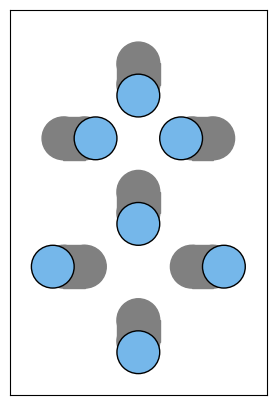

In [132]:
fig, ax = plt.subplots(figsize=(5,5))

ice.draw_frame(trj, frame_no=0,
               region=[0,60,0,90],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

plt.show()

In [65]:
x = (trj['x'] + trj['cx']).to_numpy()
y = (trj['y'] + trj['cy']).to_numpy()
z = (trj['z'] + trj['cz']).to_numpy()

In [88]:
def force_dir(r,B):
    rcb = np.cross(r,B)
    return 2*np.cross(rcb,B) - 2*r + 5*r*np.dot(rcb,rcb)

In [158]:
r1 = np.array([0,0,0])
r2 = np.array([1,0,0])
Bhat = np.array([0,0,1])
rhat = r1-r1
force_dir(rhat,Bhat)

array([-1,  0,  0])

In [100]:
positions = np.vstack([x,y,z]).T
factor = (3*params['mu0']*params['m']**2)/(4*np.pi)
factor = factor.to(ureg.piconewton * ureg.micrometer**4)
factor


<Quantity(38880.0, 'piconewton * micrometer ** 4')>

In [155]:
Bhat = np.array([1,0,0])
forces = []
for i,r1 in enumerate(positions):
    
    force = np.array([0,0,0])*ureg.piconewton
    
    for j,r2 in enumerate(positions):
        
        R = r1 - r2 
        distance = np.linalg.norm(R)
        if distance == 0:
            continue
           
        rhat = R/distance 
        distance = distance*ureg.um
        force = force + factor/distance**4 * force_dir(rhat,Bhat)
        
    forces.append(force.magnitude) 

In [156]:
forces = np.asarray(forces)
fdirs = np.asarray([f/np.linalg.norm(f) for f in forces])
mags = [np.linalg.norm(f) for f in forces]
mags

[0.17339676191085193,
 0.17339676191085193,
 1.0415703968889443,
 1.0415703968889443,
 0.06875978176237114,
 0.41730395023292044,
 2.0109233739399714]

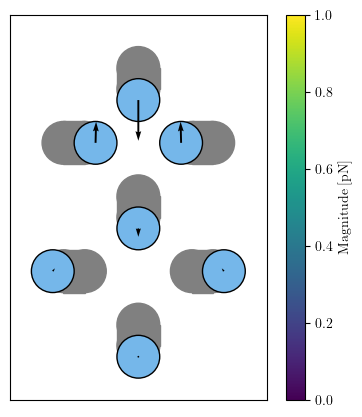

In [159]:
fig, ax = plt.subplots(figsize=(5,5))
ice.draw_frame(trj, frame_no=0,
               region=[0,60,0,90],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

#for r,f in zip(positions,forces):
#    ax.quiver(r[0],r[1],f[0],f[1],color='red')

cmap=plt.get_cmap('plasma')
#q = ax.quiver(positions[:,0],positions[:,1],fdirs[:,0],fdirs[:,1],mags,cmap=cmap)
q = ax.quiver(positions[:,0],positions[:,1],forces[:,0],forces[:,1])
cbar = plt.colorbar(q, ax=ax)
cbar.set_label('Magnitude [pN]')
plt.show()